# Coursera Machine Learning by Andrew Ng
## Programming Exercise 2: Logistic Regression
본 과제는 매트랩으로 진행되는 과제이나, 매트랩에 익숙하지 않은 관계로 파이썬으로 구현하였다.

과제 설명 파일에 제시된 부분을 구현하였다. 과제 설명과 매트랩 파일의 힌트를 참고하였다. 이번 주차는 매트랩 파일에 작성된 코드의 난이도가 저번보다 다소 높아져서 약간 귀찮았다. 앞으로는 매트랩으로 짜는게 빠를수도 있겠다는 생각이 든다...

**보고서 대신 코드와 설명, 주석을 함께 작성한 해당 파일을 첨부드립니다.**

## Introduction
* one-vs-all logistic regression 구현
* 뉴럴 네트워크 구현

### Files included
* ex3data1.mat - 트레이닝 데이터. mat 파일로 주어져서 변환 필요해 보임.
* ex3weights.mat - 뉴럴 네트워크 연습문제를 위한 초기 가중치 값
* 구현해야 할 것
    * IrCostFunction.m : 로지스틱 회귀 코스트
    * oneVsAll.m : Train a one-vs-all multi-class classifier
    * predictOneVsAll.m : 로지스틱 회귀 예측
    * predict.m : 신경망 예측

## 1. Multi-class Classification
Logistic regression과 neural networks를 사용해서 필기체 숫자를 인식할 것이다.

이전의 logistic regression을 확장해서 one-vs-all classification에 적용할 것이다.

### 1.1 Dataset
ex3data1.mat 설명 - 20X20 grayscale인 500개의 숫자 이미지 training example

숫자 1 ~ 9는 1 ~ 9로 라벨링, 숫자 0은 10으로 라벨링된 데이터

### 1.2 Visualizing the data
* 해야 할 것 : .mat 파일을 변환할 것인지, 아니면 파이썬에서 mat 파일을 읽어올 수 있는지

In [ ]:
#!pip install scipy

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import io
import random
import math

In [70]:
# %% Setup the parameters you will use for this part of the exercise
input_layer_size  = 400  #% 20x20 Input Images of Digits
num_labels = 10          #% 10 labels, from 1 to 10
                          #% (note that we have mapped "0" to label 10)
    
#%% =========== Part 1: Loading and Visualizing Data =============
#%  We start the exercise by first loading and visualizing the dataset.
#%  You will be working with a dataset that contains handwritten digits.

data = io.loadmat('ex3data1.mat') #matlab 파일을 읽어온다.

X = data['X']
y = data['y']

print(X.shape)
print(y.shape)
print(y[:10])

y = y.ravel()
print(y[:10])

(5000, 400)
(5000, 1)
[[10]
 [10]
 [10]
 [10]
 [10]
 [10]
 [10]
 [10]
 [10]
 [10]]
[10 10 10 10 10 10 10 10 10 10]


In [71]:
m = X.shape[0]
print(m)

#% Randomly select 100 data points to display
rand_indices = np.arange(m)
random.shuffle(rand_indices) #random.shuffle이 randperm과 같은 역할.
sel = X[rand_indices[:100,], :]
print(sel.shape)

5000
(100, 400)


In [72]:
def displayData(X, example_width=0):
    #% Set example_width automatically if not passed in
    if example_width == 0:
        example_width = round(np.sqrt(X.shape[1]))
        
    # Compute rows, cols
    m, n = X.shape
    example_height = (n/example_width)
    print(example_width, example_height)
    
    #% Compute number of items to display
    display_rows = math.floor(np.sqrt(m))
    display_cols = math.ceil(m/display_rows)
    print(display_rows, display_cols)
    
    pad = 1
    #% Setup blank display
    # 오류발생 : TypeError: 'numpy.float64' object cannot be interpreted as an integer
    # example_width, height는 floot형이므로 integer형으로 바꿔줌.
    example_width = int(example_width)
    example_height = int(example_height)
    display_array = np.ones((pad+display_rows * (example_height+pad), pad+display_cols * (example_width+pad)))
    
    # Copy each example into a patch on the display array
    curr_ex = 0
    for j in np.arange(display_rows, dtype=int):
        for i in np.arange(display_cols, dtype=int):
            if curr_ex >= m:
                break
                
            # Copy the patch
            
            # Get the max value of the patch
            max_val = np.max(np.abs(X[curr_ex, :]))

            # 인덱스 주의: matlab에서 인덱스는 1부터 시작. 파이썬에 맞게 바꿔줌. (j - 1) => j, (i - 1) => i
            #x = pad + j * (example_height + pad) + np.arange(example_height, dtype=int)
            #y = pad + i * (example_width + pad) + np.arange(example_width, dtype=int)

            x = pad + j * (example_height + pad)
            y = pad + i * (example_width + pad)
            
            display_array[x:x + example_height, y: y + example_width] = X[curr_ex, :].reshape((example_height, example_width)).T / max_val; #reshape하고 transpose

            curr_ex = curr_ex + 1
            
            if curr_ex >= m:
                break

    plt.set_cmap('gray')
    plt.imshow(display_array)

    # 축을 보여주지 않는다.
    plt.axis('off')
    #show()

20.0 20.0
10 10


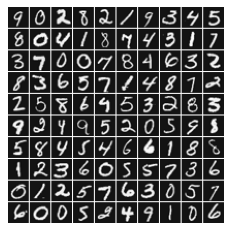

In [73]:
displayData(sel)

### 1.3 Vectorizing Logistic Regression
* 10개의 클래스이므로 10개의 logistic regression을 training해야 함.
* 이 트레이닝을 효율적으로 하기 위해 코드가 잘 벡터화되는 것이 중요하다.
* 어떠한 for-loop도 사용하지 않는 벡터화 버전을 짜라.

#### 1.3.1 Vectorizing the cost function
* IrCostFunction에서 unregularized cost 함수를 작성해라.
* 어떠한 loop도 포함하지 않아야 함.

#### 1.3.2 Vectorizing the gradient
* 모든 theta에 대한 모든 편미분 값을 작성

#### 1.3.3 Vectoriziting regularized logistic regression
* cost function에 regularization
* bias로 사용되는 theta0은 regularization해서는 안 된다!!

In [74]:
def sigmoid(z):
    g = 1/(1+np.exp(-z))
    return g

In [75]:
print(sigmoid(10), sigmoid(-10), sigmoid(0))

0.9999546021312976 4.5397868702434395e-05 0.5


In [76]:
def IrCostFunction(theta, X, y, lambda_):
    
    #% Initialize some useful values
    m, n = X.shape #% number of training examples
    
    J=0
    grad = np.zeros(np.size(theta))
    
    theta_sum = np.sum(theta[1:]**2) #theta[0]는 포함하지 않는다.
    
    X_theta = X.dot(theta)
    hypothesis = sigmoid(X_theta)
    
    # cost 계산
    # TypeError: only size-1 arrays can be converted to Python scalars
    J = 1/m * np.sum(-y * math.log(hypothesis) - (1-y) * math.log(1-hypothesis)) + lambda_/(2*m)*theta_sum
    
    # cost의 편미분 계산
    delta = 1/m * (hypothesis-y).T.dot(X)
    
    # regularization
    temp = theta
    temp[0] = 0 #theta[0]는 regularization하지 않는다.
    regular = (lambda_/m)*temp
    
    grad = delta+regular
    
    return J, grad    

In [77]:
# % Test case for lrCostFunction
# printf('\nTesting lrCostFunction() with regularization');

# theta_t = [-2; -1; 1; 2];

# X_t = [ones(5,1) reshape(1:15,5,3)/10];
# y_t = ([1;0;1;0;1] >= 0.5);
# lambda_t = 3;

# [J grad] = lrCostFunction(theta_t, X_t, y_t, lambda_t);

# fprintf('\nCost: %f\n', J);
# fprintf('Expected cost: 2.534819\n');
# fprintf('Gradients:\n');
# fprintf(' %f \n', grad);
# fprintf('Expected gradients:\n');
# fprintf(' 0.146561\n -0.548558\n 0.724722\n 1.398003\n');

# fprintf('Program paused. Press enter to continue.\n');
# pause;

In [80]:
# Test case for IrCostFunction
theta_t = np.array([-2,-1,1,2])
# X_t = [ones(5,1) reshape(1:15,5,3)] #매트랩에서 reshape 인자가 뭘 의미하는지 잘 모르겟다.
#X_t = np.ones(5,1).reshape(1:15,5,3)
X_1 = np.array([[1, 8, 1, 6],
    [1, 3, 5, 7],
    [1, 4, 9, 2]])
y_1 = np.array([1,0,1])
#TypeError: only size-1 arrays can be converted to Python scalars
y_2 = (y_1 >= 0.5)
print(y_2.astype(int))

lambda_ = 3
J, grad = IrCostFunction(theta_t, X_1, y_2.astype(int), lambda_)
print(J, grad)

[1 0 1]


TypeError: only size-1 arrays can be converted to Python scalars

### 1.4 One-vs-all Classification

In [59]:
# 우선 fminunc 대신 minimize 기능을 제공하는 scipy 라이브러리를 임포트함.
from scipy.optimize import minimize

In [85]:
def oneVsAll(X, y, num_labels, lambda_):
    m, n = X.shape
    
    all_theta = np.zeros((num_labels, n+1))
    
    #% Add ones to the X data matrix
    X = np.hstack((np.ones((m,1)), X)) #1 컬럼을 추가
    
    fmincfg_cost = lambda t: IrCostFunction(t, X, y_t.astype(int), lambda_)[0]
    fmincfg_grad = lambda t: IrCostFunction(t, X, y_t.astype(int), lambda_)[1]
    
    for i in np.arange(num_labels):
        i += 1 #인덱스 1부터 시작
        init_theta = np.zeros(n+1)
        
        y_t = (y==i)
        res = minimize(fun=fmincfg_cost, x0=init_theta, method='CG', jac=fmincfg_grad, options={'maxiter':50})
        theta_all[i-1, :] = res.x
    
    return teata_all
        

In [86]:
lambda_1 = 0.1
theta_all = oneVsAll(X, y, num_labels, lambda_1)
print(theta_all[0, 0:5])

TypeError: only size-1 arrays can be converted to Python scalars

#### 1.4.1 One-Vs-All Prediction
입력 이미지가 훈련된 logistic regression classifier를 사용해서 각 클래스에 포함될 확률을 계산해라.
* predictOneVsAll.m 구현하기
* **training set 정확도는 94.9%여야 한다.**

In [111]:
def predictOneVsAll(theta, X):
    pass

# 2. Neural Networks
feedforward propagation으로, ex3_nn.m 이용

## 2.1 Model representation

## 2.2 Feedforward Propagation and Prediction

20.0 20.0
10 10


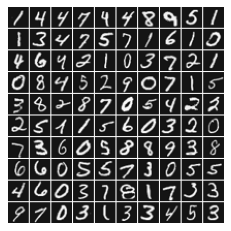

In [97]:
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10

data = io.loadmat('ex3data1.mat') #matlab 파일을 읽어온다.

X_n = data['X']
y_n = data['y']
y_n = y_n.ravel()
m = X_n.shape[0]

rand_index = np.arange(m)
random.shuffle(rand_index)

sel = X_n[rand_index[0:100, ], :]
displayData(sel)

In [98]:
theta = io.loadmat('ex3weights.mat')

In [99]:
theta1 = theta['Theta1']
theta2 = theta['Theta2']

In [105]:
def predict(theta1, theta2, X_n):
    m = X_n.shape[0]
    p = np.zeros(m)
    
    X_n = np.hstack((np.ones((m,1)), X_n))
    z = theta1.dot(X_n.T)
    a2 = sigmoid(z)
    
    a2=a2.T
    
    a2 = np.hstack((np.ones((a2.shape[0],1)), a2))
    z = theta2.dot(a2.T)
    a3 = sigmoid(z)
    
    p = np.argmax(a3, axis=0)
    p+=1
    
    return p

In [108]:
pred = predict(theta1, theta2, X_n)
print("Accuracy: %s" % (np.mean(np.double(pred==y_n))*100))

Accuracy: 97.52


20.0 20.0
1 1


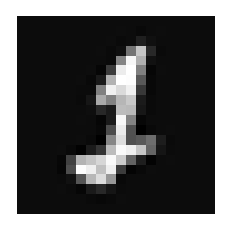

Neural network pred: [1], real digit: 2
20.0 20.0
1 1


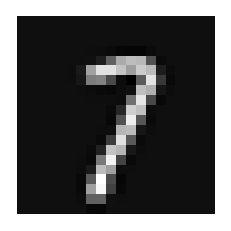

Neural network pred: [7], real digit: 7
20.0 20.0
1 1


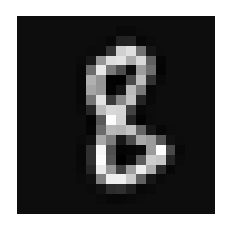

Neural network pred: [8], real digit: 8
20.0 20.0
1 1


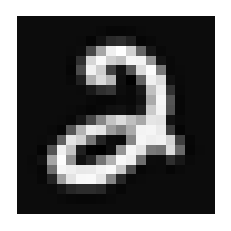

Neural network pred: [2], real digit: 2
20.0 20.0
1 1


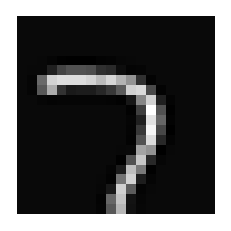

Neural network pred: [7], real digit: 7


In [110]:
rand_idx = np.arange(m)
random.shuffle(rand_idx)

# 임의로 선택한 5개 출력
for i in np.arange(5):
    idx = rand_idx[i]
    test = np.array([X_n[idx, :]])
    displayData(test)
    plt.show()
    
    pred = predict(theta1, theta2, test)
    print("Neural network pred: %s, real digit: %s" %(pred, y[idx]))